  # Policy compared to Covid-19 Case Rate

All the typical caviates apply...
   - for example testing goes up through time... so case rate is skewed through time

## Bring in df and aggregate to index by date for all of UK

In [391]:
import numpy as np
import pandas as pd

In [392]:
df = pd.read_csv('cases_analysis.csv')
df.drop(columns = ('Unnamed: 0'), inplace = True)
# make wrapped line plots of cases through time

In [393]:
# so to get uk overall, may need to do several aggregations and merge

In [394]:
# for now let's drop category data and will reattach later
#df = df[df.columns[0:13]]
#df = df.drop(df.iloc[:, 0:3], inplace = True, axis = 1) 

In [395]:
#df1 = df.groupby('date').sum()
#df1.drop(df1.iloc[:, 1:2], inplace = True, axis=1)
#df1.drop(columns = ['days_since_first', 'case_rate_in_2_weeks', 'case_rate_on_day', ''])
# nope just gonna start from scratch wayyy easier that way 
df = pd.read_csv('UK_cases.csv')
df.drop(columns=['Area name', 'Area code', 'Area type'], inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# create daily lab confirmed cases
df['Cumulative lab-confirmed cases rate'] = df['Cumulative lab-confirmed cases rate'].astype(float)

df['Daily_lab_confirmed_case_rate'] = df['Cumulative lab-confirmed cases rate'].diff()
df = df.dropna()

<AxesSubplot:xlabel='Date'>

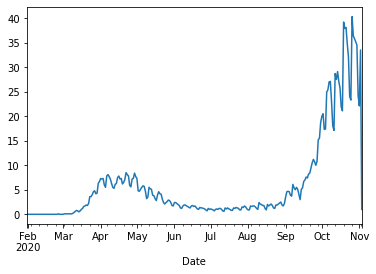

In [396]:
# now plot date anf Daily lab_confirmed_case_rate
df = df.set_index('Date')
df['Daily_lab_confirmed_case_rate'].plot()

<AxesSubplot:xlabel='Date'>

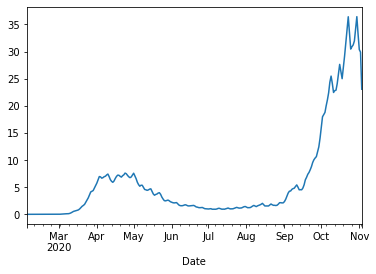

In [397]:
# create 7 day rolling ave
df['7_day_rolling_ave'] = df['Daily_lab_confirmed_case_rate'].rolling(window=5).mean()
df = df.dropna()
df['7_day_rolling_ave'] = df['7_day_rolling_ave'].astype(float)
df['7_day_rolling_ave'].plot()
# looks nice and smooth now

<AxesSubplot:xlabel='Date'>

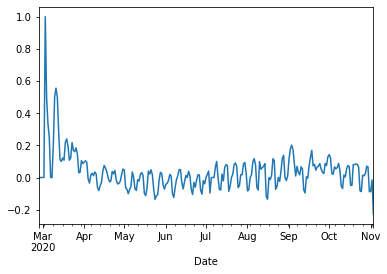

In [398]:
# now want to put on a zero scale i.e. from one day to the next what is the difference?
# does case rate go up or down? (on 7 day rolling ave)
# I want the % change not the difference, that way it's relative
df['pctchange_in_case_rate'] = df['7_day_rolling_ave'].pct_change()
df = df.dropna()# drop first row
df = df.drop(df.index[0])
# so - means case rate goes down, + means case rate goes up

# now want a % change from current day rolling ave to rolling ave in 2 weeks
df1 = df[['7_day_rolling_ave']]
df['pctchange_in_case_rate'].plot()

In [399]:
# + means cases going up

In [400]:
# then adapt this to a column to line up with 2 weeks in the future
# add date for 2 weeks in future
df1 = df1.reset_index()
from datetime import timedelta

df1['Date_in_2weeks'] = df1['Date'] + timedelta(days=14)
temp = df1[['Date', '7_day_rolling_ave']]
temp.rename(columns = {'7_day_rolling_ave': '7_day_rolling_ave_in_2weeks'}, inplace=True)
df1 = pd.merge(df1, temp, how='left', left_on=('Date_in_2weeks'), right_on=('Date'))
#what's the % change in rolling ave case rate today and two weeks from now
# two weeks from now did case rate go up or down 

C:\Users\stuar\anaconda3\lib\site-packages\pandas\core\frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [401]:
df1 = df1.dropna()
# now % change in rolling average from current day to two weeks from now 
#df1['pct_change_between_now_and_two_weeks'] = df1[['7_day_rolling_ave', '7_day_rolling_ave_in_2weeks']].pct_change(axis=1)
df1['pct_change_between_now_and_two_weeks'] =   df1[['7_day_rolling_ave', '7_day_rolling_ave_in_2weeks']].apply(lambda row: (row.iloc[0]-row.iloc[1])/row.iloc[0]*100, axis=1)

# make % change + means increase in number of cases - means decrease in number of cases
df1['pct_change_between_now_and_two_weeks'] = df1['pct_change_between_now_and_two_weeks'] * -1

In [402]:
# making sure 2week movement worked
df1[df1['Date_x'] == '2020-03-16']

,Date_x,7_day_rolling_ave,Date_in_2weeks,Date_y,7_day_rolling_ave_in_2weeks,pct_change_between_now_and_two_weeks
18,2020-03-16,0.74,2020-03-30,2020-03-30,4.84,554.054054


In [403]:

# so basically a massive increase in percent change increase at start and after april may start to get the first dips in 
#covid cases i.e. if cases in two weeks were to be less than today there would be a negative - number 

# percent change between day and two weeks from day

In [404]:
# so do covid cases go up or down based on policies

In [405]:
df1 = df1[['Date_x', 'Date_in_2weeks', '7_day_rolling_ave_in_2weeks','pct_change_between_now_and_two_weeks']]
df = df.reset_index()
df = pd.merge(df, df1, how='left', left_on=('Date'), right_on='Date_x')
df = df.drop(columns = ['Date_x'])

In [406]:
policy = pd.read_csv('Policy_for_analysis.csv')
policy = policy.drop(columns = ['Introduced by'])
policy['Date'] = pd.to_datetime(policy['Date'])
policy = policy.rename(columns = {'Date':'Date_1'})
df = pd.merge(df, policy, how='left', left_on=('Date'), right_on=('Date_1'))
#df = df.drop(columns = ['Date_y'])

# if want just set rows then needs to 
policy2 = policy.drop_duplicates(['Date_1'])
df_left = pd.merge(df,policy2.drop_duplicates(),how='left', left_on=('Date'), right_on=('Date_1'))

In [407]:
df

,Date,Daily lab-confirmed cases,Cumulative lab-confirmed cases,Cumulative lab-confirmed cases rate,Daily_lab_confirmed_case_rate,7_day_rolling_ave,pctchange_in_case_rate,Date_in_2weeks,7_day_rolling_ave_in_2weeks,pct_change_between_now_and_two_weeks,Date_1,Policy,Category,Deemed_sig_by_tracker
0,2020-02-27,7,38,0.1,0.0,0.02,0.000000,2020-03-12,0.42,2000.0,NaT,NaN,NaN,NaN
1,2020-02-28,11,49,0.1,0.0,0.02,0.000000,2020-03-13,0.54,2600.0,2020-02-28,NHS rolls out services on NHS sites to test pe...,"Testing, surveillance and contact tracing",1.0
2,2020-02-29,5,54,0.1,0.0,0.02,0.000000,2020-03-14,0.60,2900.0,NaT,NaN,NaN,NaN
3,2020-03-01,20,74,0.1,0.0,0.02,0.000000,2020-03-15,0.66,3200.0,NaT,NaN,NaN,NaN
4,2020-03-02,39,113,0.2,0.1,0.02,0.000000,2020-03-16,0.74,3600.0,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,2020-10-30,19380,888579,1578.7,34.5,36.44,0.065497,NaT,NaN,NaN,NaT,NaN,NaN,NaN
410,2020-10-31,13649,902228,1602.9,24.2,33.22,-0.088364,NaT,NaN,NaN,NaT,NaN,NaN,NaN
411,2020-11-01,12457,914685,1625.0,22.1,30.36,-0.086093,NaT,NaN,NaN,NaT,NaN,NaN,NaN
412,2020-11-02,18826,933511,1658.5,33.5,29.90,-0.015152,NaT,NaN,NaN,NaT,NaN,NaN,NaN


In [408]:
df.isnull().sum()
# so last two weeks and 118 days where no policies eneacted
# there's also the issue of if two or more policies are on the same day, only the first is enacted

Date                                      0
Daily lab-confirmed cases                 0
Cumulative lab-confirmed cases            0
Cumulative lab-confirmed cases rate       0
Daily_lab_confirmed_case_rate             0
7_day_rolling_ave                         0
pctchange_in_case_rate                    0
Date_in_2weeks                           14
7_day_rolling_ave_in_2weeks              14
pct_change_between_now_and_two_weeks     14
Date_1                                  118
Policy                                  118
Category                                119
Deemed_sig_by_tracker                   118
dtype: int64

# What the XGBoost Model Showed 

We'll use these F-values to determine the policies to examine as they have the greatest correlation with predicting COVID cases.. 
   1. Deemed significant by policy tracker
   2. Social Distancing Measures
   2. Testing, surveillance and contact tracing
   3. Infection prevention and control

In [409]:
df.Category.unique()

array([nan, 'Testing, surveillance and contact tracing',
       'Informing the public', 'Legal change', 'Other', 'Travel measures',
       'Social distancing measures', 'Health and social care settings',
       'Non-health and social care settings', 'SAGE papers',
       'Shielding measures', 'Infection prevention and control',
       'Vaccine', 'Monitoring, Testing'], dtype=object)

In [410]:
# get ave % change in case rate for each catergory
SDM = df[df['Category']=='Social distancing measures']
TSC = df[df['Category']=='Testing, surveillance and contact tracing']
IPC = df[df['Category']=='Infection prevention and control']

In [411]:
 # i.e. with such and such policy what is the percent change in confirmed COVID case rate

### Deemed significant by tracker

### Social Distancing Measures

In [412]:
print('Number of policies', len(SDM))
print(SDM['pct_change_between_now_and_two_weeks'].describe()) # so still an average increase in case rate
SDM['pct_change_between_now_and_two_weeks'].median() # but in general these policys lead to a decrease in case rate
# 23% reduction in case rate if a policy of this type is enacted

Number of policies 76
count     76.000000
mean      49.664667
std      163.517554
min      -47.282609
25%      -34.435096
50%      -23.971774
75%       32.674867
max      757.142857
Name: pct_change_between_now_and_two_weeks, dtype: float64


-23.97177419354827

In [413]:
Temp = SDM[['Date','Policy','pct_change_between_now_and_two_weeks']].nsmallest(10, 'pct_change_between_now_and_two_weeks')
Policy_list = list(Temp['Policy'].values)
print(Policy_list)


print("key dates seem to be the 21st and 22nd as one group, 03/04 as another, and 13/14th")
# seem to be clusters of dates, could do some unsupervised clustering to get key dates of policy
Temp 

['Transport Secretary announces £283 million has been made available to increase the number of bus and light rail services so that people who need to travel can do so safely', 'Guidance is published to help local authorities across England deliver activities supported through the Reopening High Streets Safely Fund - £50 million from the European Regional Development Fund to support the safe reopening of high streets and other commercial areas', 'PM confirms schools, colleges and nurseries on track to begin phased reopening from 1 June ', 'Government publishes social distancing guidance for young people', 'Plans are announced for London’s COVID-19 recovery with a new London Transition Board to co-ordinate the transition out of lockdown ', 'Closing certain businesses and venues guidance is updated to reflect new regulations ', 'New guidance on spending time outdoors - Coronavirus (COVID-19): safer public places - urban centres and green spaces', 'Guidance is published on the phased retur

,Date,Policy,pct_change_between_now_and_two_weeks
169,2020-05-23,Transport Secretary announces £283 million has...,-47.282609
170,2020-05-24,Guidance is published to help local authoritie...,-46.540881
171,2020-05-24,"PM confirms schools, colleges and nurseries on...",-46.540881
173,2020-05-24,Government publishes social distancing guidanc...,-46.540881
164,2020-05-22,Plans are announced for London’s COVID-19 reco...,-45.728643
142,2020-05-13,Closing certain businesses and venues guidance...,-44.888889
143,2020-05-13,New guidance on spending time outdoors - Coron...,-44.888889
144,2020-05-13,Guidance is published on the phased return of ...,-44.888889
146,2020-05-14,Guidance on critical workers updated to reflec...,-44.827586
152,2020-05-15,Government announce new taskforce to develop p...,-44.255319


### Testing, surveillance and contact tracing

In [414]:
print('Number of policies', len(TSC))
print(TSC['pct_change_between_now_and_two_weeks'].describe()) # so still an average increase in case rate #ave is higher
TSC['pct_change_between_now_and_two_weeks'].median() # but in general these policys lead to a decrease in case rate
# 26% reduction in case rate if a policy of this type is enacted

Number of policies 66
count      66.000000
mean       57.252965
std       350.591531
min       -45.728643
25%       -36.751788
50%       -26.373626
75%         7.649306
max      2600.000000
Name: pct_change_between_now_and_two_weeks, dtype: float64


-26.373626373626358

In [415]:
# so what were the actual policies?

# can check here to see if other policies on that day

# can also throw in policies from day before and after as resonable to assume influential / relevent

In [416]:
# Top ten policies correlated with drop in case rate
#TSC.nsmallest(10, 'pct_change_between_now_and_two_weeks')

Temp = TSC[['Date','Policy','pct_change_between_now_and_two_weeks']].nsmallest(10, 'pct_change_between_now_and_two_weeks')
Policy_list = list(Temp['Policy'].values)
print(Policy_list)


print("key dates seem to be the 21st and 22nd as one group, 03/04 as another, and 13/14th")
# seem to be clusters of dates, could do some unsupervised clustering to get key dates of policy
Temp 

['Guidance published on the government’s coronavirus antibody testing programme ', 'Science and Technology Committee question Public Health England on the decisions made to stop contact tracing in March \n', 'Government announce £300m additional funding for local authorities to support new test and trace service called the Local authority test and trace service support grant', 'A rapid COVID-19 test which can return results on site within 20 minutes starts to be trialled in a number of A&E departments, GP testing hubs and care homes in Hampshire', 'Government announces the start of a new national antibody testing programme, with plans to provide antibody tests to NHS and care staff in England from the end of May', 'A guide to COVID-19 tests and testing kits is published for patients, the public and professional users', 'Government announces expansion of the expert team leading on the nationwide roll-out of the test and trace programme', 'Personal care assistants are added to the list o

,Date,Policy,pct_change_between_now_and_two_weeks
162,2020-05-22,Guidance published on the government’s coronav...,-45.728643
163,2020-05-22,Science and Technology Committee question Publ...,-45.728643
165,2020-05-22,Government announce £300m additional funding f...,-45.728643
160,2020-05-21,A rapid COVID-19 test which can return results...,-45.408163
161,2020-05-21,Government announces the start of a new nation...,-45.408163
145,2020-05-13,A guide to COVID-19 tests and testing kits is ...,-44.888889
141,2020-05-12,Government announces expansion of the expert t...,-42.986425
116,2020-05-03,Personal care assistants are added to the list...,-42.857143
117,2020-05-04,"Government announces that 'test, track and tra...",-40.540541
119,2020-05-04,Unpaid carers are added to the list of essenti...,-40.540541


### Infection Prevention and Control

In [417]:
print('Number of policies', len(IPC))
print(IPC['pct_change_between_now_and_two_weeks'].describe()) # so still an average increase in case rate #ave is higher
IPC['pct_change_between_now_and_two_weeks'].median() 
# fairly minimal reduction of 8%

Number of policies 35
count    35.000000
mean     -4.633152
std      37.046295
min     -44.827586
25%     -35.296842
50%      -8.611111
75%      13.226507
max      96.891192
Name: pct_change_between_now_and_two_weeks, dtype: float64


-8.611111111111173

In [418]:
Temp = IPC[['Date','Policy','pct_change_between_now_and_two_weeks']].nsmallest(10, 'pct_change_between_now_and_two_weeks')
Policy_list = list(Temp['Policy'].values)
print(Policy_list)


print("key dates seem to be the 21st and 22nd as one group, 03/04 as another, and 13/14th")
# seem to be clusters of dates, could do some unsupervised clustering to get key dates of policy
Temp 

['Guidance is published on preventing and controlling infection, including the use of PPE, in education, childcare and children’s social care settings ', 'Government announces that more than 70 million face masks will be manufactured in the UK and delivered to frontline health and care workers following an agreement with a global technology company', 'Government announces a care home support package, funded by a £600m adult social care infection control fund ', 'Considerations for acute personal protective equipment (PPE) shortages guidance is updated on the use of certain facemasks', 'Government publishes guidance for employers to help them get their businesses back up and running and workplaces operating safely', 'The public is advised to consider wearing face coverings in enclosed public spaces such as shops, trains and buses to help reduce the spread of COVID-19', 'Guidance published on how to wear and make a cloth face covering', 'Government signs deals with more than 100 new  PPE

,Date,Policy,pct_change_between_now_and_two_weeks
149,2020-05-14,Guidance is published on preventing and contro...,-44.827586
150,2020-05-15,Government announces that more than 70 million...,-44.255319
151,2020-05-15,Government announces a care home support packa...,-44.255319
115,2020-05-02,Considerations for acute personal protective e...,-40.281690
133,2020-05-11,Government publishes guidance for employers to...,-37.610619
134,2020-05-11,The public is advised to consider wearing face...,-37.610619
135,2020-05-11,Guidance published on how to wear and make a c...,-37.610619
176,2020-05-26,Government signs deals with more than 100 new ...,-37.301587
110,2020-04-30,Treasury introduces zero-rate of VAT for PPE -...,-35.911602
105,2020-04-27,Guidance published on 'how to work safely in d...,-34.682081


### What were the main dates in curbing the spread?

In [419]:
df_single = df.drop_duplicates(['Date'])

In [420]:
df_single[['Date', 'pct_change_between_now_and_two_weeks']].nsmallest(30, 'pct_change_between_now_and_two_weeks')

,Date,pct_change_between_now_and_two_weeks
169,2020-05-23,-47.282609
170,2020-05-24,-46.540881
162,2020-05-22,-45.728643
160,2020-05-21,-45.408163
142,2020-05-13,-44.888889
146,2020-05-14,-44.827586
150,2020-05-15,-44.255319
159,2020-05-20,-43.850267
174,2020-05-25,-43.262411
139,2020-05-12,-42.986425


Key Dates of Decrease
   1. 2020-05-19th to 27th 
   2. 2020-05-13th to 19th 
   3. 2020-05-03rd to 5th 
   4. 2020-06-15th to 19th
   5. 2020-04-26th to 30th 

In [421]:
# corresponding policies
df_sig1 = df[(df['Date'] >= '2020-05-13') & (df['Date'] <= '2020-05-27')]
print(df_sig1.shape)
df_sig2 = df[(df['Date'] >= '2020-05-03') & (df['Date'] <= '2020-05-05')]
print(df_sig2.shape)
df_sig3 = df[(df['Date'] >= '2020-06-15') & (df['Date'] <= '2020-06-19')]
print(df_sig3.shape)
df_sig4 = df[(df['Date'] >= '2020-06-26') & (df['Date'] <= '2020-06-30')]
print(df_sig4.shape)

(38, 14)
(6, 14)
(9, 14)
(12, 14)


In [422]:
df_sig = df_sig1.append(df_sig2, ignore_index = True) 
df_sig = df_sig.append(df_sig3, ignore_index = True) 
df_sig = df_sig.append(df_sig4, ignore_index = True)

,Date,Daily lab-confirmed cases,Cumulative lab-confirmed cases,Cumulative lab-confirmed cases rate,Daily_lab_confirmed_case_rate,7_day_rolling_ave,pctchange_in_case_rate,Date_in_2weeks,7_day_rolling_ave_in_2weeks,pct_change_between_now_and_two_weeks,Date_1,Policy,Category,Deemed_sig_by_tracker
0,2020-05-13,2880,187999,334.0,5.1,4.50,0.018100,2020-05-27,2.48,-44.888889,2020-05-13,Closing certain businesses and venues guidance...,Social distancing measures,0.0
1,2020-05-13,2880,187999,334.0,5.1,4.50,0.018100,2020-05-27,2.48,-44.888889,2020-05-13,New guidance on spending time outdoors - Coron...,Social distancing measures,0.0
2,2020-05-13,2880,187999,334.0,5.1,4.50,0.018100,2020-05-27,2.48,-44.888889,2020-05-13,Guidance is published on the phased return of ...,Social distancing measures,0.0
3,2020-05-13,2880,187999,334.0,5.1,4.50,0.018100,2020-05-27,2.48,-44.888889,2020-05-13,A guide to COVID-19 tests and testing kits is ...,"Testing, surveillance and contact tracing",1.0
4,2020-05-14,2214,190213,337.9,3.9,4.64,0.031111,2020-05-28,2.56,-44.827586,2020-05-14,Guidance on critical workers updated to reflec...,Social distancing measures,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,2020-06-29,666,243669,432.9,1.2,1.02,-0.019231,2020-07-13,0.96,-5.882353,2020-06-29,The first local lockdown is introduced in Leic...,Social distancing measures,1.0
61,2020-06-30,570,244239,433.9,1.0,0.98,-0.039216,2020-07-14,0.94,-4.081633,2020-06-30,Guidance published on areas of Leicestershire ...,Social distancing measures,0.0
62,2020-06-30,570,244239,433.9,1.0,0.98,-0.039216,2020-07-14,0.94,-4.081633,2020-06-30,Guidance published for the safe use of council...,Non-health and social care settings,0.0
63,2020-06-30,570,244239,433.9,1.0,0.98,-0.039216,2020-07-14,0.94,-4.081633,2020-06-30,Government publishes weekly reports on PPE del...,Infection prevention and control,0.0


In [423]:
SDM_main = SDM.nsmallest(10, ['pct_change_between_now_and_two_weeks'])
TSC_main = TSC.nsmallest(10, ['pct_change_between_now_and_two_weeks'])
IPC_main = IPC.nsmallest(10, ['pct_change_between_now_and_two_weeks'])

df_sig = df_sig.append(SDM_main, ignore_index = False) 
df_sig = df_sig.append(TSC_main, ignore_index = False) 
df_sig = df_sig.append(IPC_main, ignore_index = False) 

In [430]:
df_sig.drop_duplicates(['Policy'], inplace = True)
df_sig.Category.value_counts()

Testing, surveillance and contact tracing    18
Social distancing measures                   17
Infection prevention and control             12
Non-health and social care settings          11
Health and social care settings               3
Travel measures                               2
Vaccine                                       1
Other                                         1
Informing the public                          1
Name: Category, dtype: int64

### Is There a sig difference between these event types and the norm?

In [ ]:
# now do ANOVA and compar to norm

# do ANOVA of three events and the remaining values
import researchpy as rp




In [ ]:
import seaborn as sns
sns.boxplot(x=boston_df['DIS'])

## Significant Policy List

In [367]:
# make csv, with date, policy, category, and order of importance 

In [431]:
df_sig.to_csv('significant_policies.csv')